In [1]:
### Import Libraries
import os, tempfile
from pylab import *

from CSXCAD  import ContinuousStructure
from openEMS import openEMS
from openEMS.physical_constants import *

In [2]:
### Setup the simulation
Sim_Path = os.path.join(tempfile.gettempdir(), 'Rect_WG')

post_proc_only = False
unit = 1e-6; #drawing unit in um

# waveguide dimensions
# WR42
a = 10700;   #waveguide width
b = 4300;    #waveguide heigth
length = 50000;

# frequency range of interest
f_start = 20e9;
f_0     = 24e9;
f_stop  = 26e9;
lambda0 = C0/f_0/unit;

In [3]:
#waveguide TE-mode definition
TE_mode = 'TE10';

#targeted mesh resolution
mesh_res = lambda0/50

In [4]:
### Setup FDTD parameter & excitation function
FDTD = openEMS(NrTS=1e4);
FDTD.SetGaussExcite(0.5*(f_start+f_stop),0.5*(f_stop-f_start));

# boundary conditions
FDTD.SetBoundaryCond([0, 0, 0, 0, 3, 3]);

### Setup geometry & mesh
CSX = ContinuousStructure()
FDTD.SetCSX(CSX)
mesh = CSX.GetGrid()
mesh.SetDeltaUnit(unit)

mesh.AddLine('x', [0, a])
mesh.AddLine('y', [0, b])
mesh.AddLine('z', [0, length])

In [5]:
## Apply the waveguide port
#ports = []
start=[0, 0, 10*mesh_res];
stop =[a, b, 15*mesh_res];
mesh.AddLine('z', [start[2], stop[2]])
#ports.append(FDTD.AddRectWaveGuidePort( 0, start, stop, 'z', a*unit, b*unit, TE_mode, 1))
port=FDTD.AddRectWaveGuidePort( 0, start, stop, 'z', a*unit, b*unit, TE_mode, 1)
# start=[0, 0, length-10*mesh_res];
# stop =[a, b, length-15*mesh_res];
# mesh.AddLine('z', [start[2], stop[2]])
# ports.append(FDTD.AddRectWaveGuidePort( 1, start, stop, 'z', a*unit, b*unit, TE_mode))

mesh.SmoothMeshLines('all', mesh_res, ratio=1.4)

In [6]:
### Define dump box...
Et = CSX.AddDump('Et', file_type=0, sub_sampling=[2,2,2])
start = [0, 0, 0];
stop  = [a, b, length];
Et.AddBox(start, stop);

### Run the simulation
if 0:  # debugging only
    CSX_file = os.path.join(Sim_Path, 'rect_wg.xml')
    if not os.path.exists(Sim_Path):
        os.mkdir(Sim_Path)
    CSX.Write2XML(CSX_file)
    os.system(r'AppCSXCAD "{}"'.format(CSX_file))
nf2ff = FDTD.CreateNF2FFBox()
if not post_proc_only:
    FDTD.Run(Sim_Path, verbose=3, cleanup=True)

In [7]:
port.CalcPort(Sim_Path, np.linspace(f_start, f_stop, 101))

port_ut_0
port_it_0


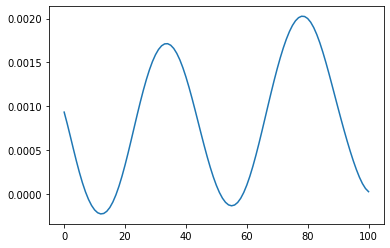

In [8]:
plt.plot(np.real(port.uf_ref/port.uf_inc))

In [19]:
theta = np.arange(-180, 180, 0.5)
phi   = [0., 45., 90.]
nf2ff_res = nf2ff.CalcNF2FF(Sim_Path, 2.4e10, theta, phi, center=[0,0,0])

In [30]:
E_norm = 20.0*np.log10(nf2ff_res.E_norm[0]/np.max(nf2ff_res.E_norm[0])) + nf2ff_res.Dmax[0]

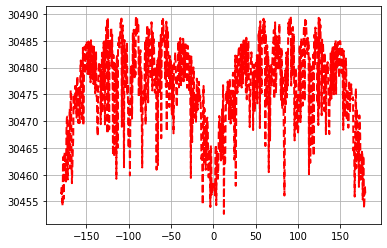

In [33]:
plt.plot(theta, np.squeeze(E_norm[:,2]), 'r--', linewidth=2, label='yz-plane')
plt.grid()

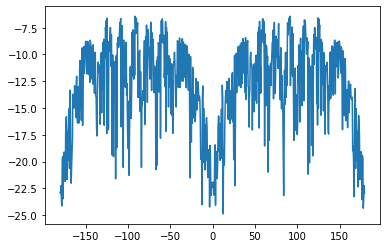

In [28]:
plt.plot(theta, 10*np.log10(nf2ff_res.E_norm[0][:,2]/np.amax(nf2ff_res.E_norm[0][:,0])))

In [13]:
len(theta)

200